In [60]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Polynomials")
Pkg.add("NPZ")
Pkg.add("DataFrames")
Pkg.add("StatsPlots")
Pkg.add("CSV")
print(VERSION)

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`


1.4.2

In [31]:
using NPZ
data = npzread("OUmt_sN05.npy")

1000×10001 Array{Float64,2}:
 0.01  -1.87761    -2.18369   …   0.103991    0.446516   -0.797876
 0.01   0.315095    0.391503      0.589589    1.07838     1.54724
 0.01   1.26449    -0.11241       0.201999   -0.0330393   0.380695
 0.01   0.270264   -0.166356     -1.12087    -0.147571    0.465649
 0.01  -0.113972    0.828783     -0.273736   -0.498122   -1.10701
 0.01  -1.46681     0.158524  …   0.614683   -0.314523    0.92442
 0.01   1.9617      1.13969      -1.00993    -1.7245     -1.42317
 0.01   0.0846742  -0.682009     -0.605891   -0.72488    -0.663328
 0.01  -0.0267296   0.785891      0.875163    0.583334    0.671638
 0.01   0.139125   -1.40436      -0.0740335  -1.12796    -1.30722
 0.01  -3.00004    -2.06471   …   1.24806     0.621185    0.199754
 0.01  -0.129275   -1.18372       0.132433   -0.21061    -0.153968
 0.01   0.408069   -0.084261      1.72293     0.655718    0.804563
 ⋮                            ⋱                           ⋮
 4.0   -0.436409    3.02066       1.54877    

In [3]:
using Plots
plot(data[1,:])

UndefVarError: UndefVarError: data not defined

In [4]:
using Polynomials
# function to calculate A and B from the dataset
function OUEM(data1sq,dataNsq,datasq,datacorr,N)
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    broots = roots(B_coef)
#    println(broots)
    B=broots[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUEMresult(data1sq,dataNsq,datasq,datacorr,N,deltat)
    A, dA, B ,dB = OUEM(data1sq,dataNsq,datasq,datacorr,N)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

OUEMresult (generic function with 1 method)

In [5]:
# function to multiply two Gaussians
function mul_gauss(mu1,mu2,sigma1,sigma2)
    mu = (mu1*sigma2^2+mu2*sigma1^2)/(sigma1^2+sigma2^2)
    sigma = sqrt(sigma1^2*sigma2^2/(sigma1^2+sigma2^2))
    return mu,sigma
end

# function to convolute two Gaussians
function con_gauss(mu1,mu2,sigma1,sigma2)
    mu = mu1 + mu2
    sigma = sqrt(sigma1^2+sigma2^2)
    return mu,sigma
end

# function to calculate helper function alpha (forward)
function alpha(y,sigmaN,A,B)
    N = length(y)
    sig_alpha = zeros(N)
    mu_alpha = zeros(N)
    mu_alpha[1],sig_alpha[1] = mul_gauss(0,y[1],sqrt(A),sigmaN)
    for i=2:N
        mu_temp,sig_temp = con_gauss(B*mu_alpha[i-1],0,sqrt(A*(1-B^2)),B*sig_alpha[i-1])
        mu_alpha[i],sig_alpha[i] = mul_gauss(mu_temp,y[i],sig_temp,sigmaN)
    end
    return mu_alpha,sig_alpha
end

function beta(y,sigmaN,A,B)
    N = length(y)
    sig_beta = zeros(N-1)
    mu_beta  = zeros(N-1)
    mu_beta[N-1],sig_beta[N-1] = y[N]/B,sqrt(sigmaN^2+A*(1-B^2))/B
    for i=(N-2):-1:1
        mu_temp,sig_temp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        mu_beta[i],sig_beta[i] = mu_temp/B,sqrt(sig_temp^2+A*(1-B^2))/B
    end
    return mu_beta,sig_beta
end

function px(y,sigmaN,A,B)
    N = length(y)
    mu_px = zeros(N)
    sig_px = zeros(N)
    exxpone = zeros(N-1)
    rho = zeros(N-1)
    mu_x = zeros(N-1)
    mu_xpone = zeros(N-1)
    mu_alpha,sig_alpha = alpha(y,sigmaN,A,B)
    mu_beta,sig_beta = beta(y,sigmaN,A,B)
    for i=1:N-1
        mu_px[i],sig_px[i] = mul_gauss(mu_alpha[i],mu_beta[i],sig_alpha[i],sig_beta[i])
        if i==N-1
            mu_tmp,sig_tmp = y[N],sigmaN
        else
            mu_tmp,sig_tmp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        end
        # these are the polynomial coefficients of the distribution
        a = 1.0/(2*sig_tmp)+1.0/(2*(A*(1-B^2)))
        b = 1.0/(2*sig_alpha[i])+B^2/(2*(A*(1-B^2)))
        c = -B/(A*(1-B^2))
        d = -mu_tmp/sig_tmp^2
        e = -mu_alpha[i]/sig_alpha[i]^2
        rho[i] = -c/(2*sqrt(a*b))
        exxpone[i] = -c/(4*a*b-c^2)
        mu_xpone[i] = (2*b*d+c*e)/(4*a*b-c^2)
        mu_x[i] = (2*a*e+d*c)/(4*a*b-c^2)
    end
    # for last one beta = 1
    mu_px[N] = mu_alpha[N]
    sig_px[N] = sig_alpha[N]
    # it seems that the sign of mu_x and mu_xpone are not accuaratly determined by this method
    # we need to correct the signs.  We chose the sign so that mu_x[i] is closest to mu_px[i]
    # and mu_xpone[i] is closeset to mu_px[i+1]
    nswitch=0
    for i=1:N-1
        dx1 = abs(mu_x[i]-mu_px[i])
        dx2 = abs(-mu_x[i]-mu_px[i])
        dxp1 = abs(mu_xpone[i]-mu_px[i+1])
        dxp2 = abs(-mu_xpone[i]-mu_px[i+1])
        if dx1>dx2
            nswitch = nswitch+1
            mu_x[i] = -mu_x[i]
        end
        if dxp1>dxp2
            nswitch = nswitch+1
            mu_xpone[i] = -mu_xpone[i]
        end
    end
    return mu_px,sig_px,rho,exxpone,mu_x,mu_xpone,nswitch
end

function px2(y,sigmaN,A,B)
    N = length(y)
    mu_px = zeros(N)
    sig_px = zeros(N)
    exxpone = zeros(N-1)
    mu_alpha,sig_alpha = alpha(y,sigmaN,A,B)
    mu_beta,sig_beta = beta(y,sigmaN,A,B)
    for i=1:N-1
        mu_px[i],sig_px[i] = mul_gauss(mu_alpha[i],mu_beta[i],sig_alpha[i],sig_beta[i])
        if i==N-1
            mu_tmp,sig_tmp = y[N],sigmaN
        else
            mu_tmp,sig_tmp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        end
        term1 = A*(1-B^2)
        term2 = term1^2 *mu_tmp*mu_alpha[i]
        term3 = B^2*mu_tmp*mu_alpha[i]*sig_alpha[i]^2
        term4 = B*mu_tmp^2*sig_alpha[i]^2
        term5 = mu_tmp*mu_alpha[i]*sig_tmp^2
        term6 = B*(mu_alpha[i]^2+sig_alpha[i]^2)*sig_tmp^2
        term7 = 2*B*mu_tmp*mu_alpha[i]*sig_alpha[i]^2*sig_tmp^2
        term8 = (mu_alpha[i]^2+sig_alpha[i]^2)*sig_tmp^4
        term9 = B^2*sig_alpha[i]^4*(mu_tmp^2+sig_tmp^2)
        term10 = (B^2*sig_alpha[i]^2+sig_tmp^2+term1)^2
        exxpone[i] = (term2 +term1*(term3+term4+term5+term6)+B*(term7+term8+term9))/term10
        
    end
    # for last one beta = 1
    mu_px[N] = mu_alpha[N]
    sig_px[N] = sig_alpha[N]
    return mu_px,sig_px,exxpone
end

px2 (generic function with 1 method)

In [6]:
function OUWN(data,A_s,B_s,sigN_s,convth,itermax=10000)
    N=length(data)
    A_p = A_s
    B_p = B_s
    sigN_p = sigN_s
    for i=1:itermax
        mu_px,sig_px,exxpone = px2(data,sigN_p,A_p,B_p)
        # lets calculate all the values that we need for OU analysis
        # data1sq,dataNsq,datasq,datacorr
        data1sq = sig_px[1]^2 + mu_px[1]^2
        dataNsq = sig_px[end]^2 + mu_px[end]^2
        datasq = sum(sig_px[2:end-1].^2 .+ mu_px[2:end-1].^2)
        datacorr = sum(exxpone)
        global A,dA,B,dB,sigmaN
        A,dA,B,dB=OUEM(data1sq,dataNsq,datasq,datacorr,N)
        sigmaN = sqrt((sum(sig_px .^2) + sum(mu_px .^2) + sum(data .^2) -2*sum((mu_px .* data)))/length(data))
#        println("A: ",A,"  B: ",B,"  SigmaN: ",sigmaN)
        Arel = abs((A-A_p)/A_p)
        Brel = abs((B-B_p)/B_p)
        srel = abs((sigmaN-sigN_p)/sigN_p)
        if (Arel<convth && Brel<convth && srel<convth)
            break
        end
        A_p = A
        B_p = B
        sigN_p = sigmaN
    end
    return A,dA,B,dB,sigmaN
end

OUWN (generic function with 2 methods)

In [32]:
using DataFrames
# iterate over the dataset and estimate the best parameters
paradf = DataFrame(dt=Float64[],A=Float64[],dA=Float64[],B=Float64[],dB=Float64[],sigmaN=Float64[])
for i=1:size(data,1)
    dt = data[i,1]
    ts = data[i,2:end]
    Bg = exp(-dt)
    result = collect(OUWN(ts,1.0,Bg,0.5,0.0001))
    push!(paradf,pushfirst!(result,dt))
end
paradf

,dt,A,dA,B,dB,sigmaN
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.01,1.08626,0.159642,0.990854,0.00134422,0.500037
2,0.01,1.07464,0.162053,0.99139,0.00129839,0.498834
3,0.01,0.925471,0.123341,0.988966,0.00147051,0.503385
4,0.01,1.07908,0.156615,0.990725,0.00134609,0.501257
5,0.01,1.04388,0.149837,0.990493,0.00136457,0.501161
6,0.01,0.961766,0.132662,0.989716,0.00141858,0.501622
7,0.01,1.13384,0.17078,0.991271,0.0013148,0.498584
8,0.01,0.97696,0.135632,0.989848,0.00140937,0.507725
9,0.01,1.02628,0.142659,0.989875,0.00140739,0.505748


In [57]:
paradf_clean = paradf[paradf[!,:B].>0,:]
paradf_clean[!,:tau] = -paradf_clean[!,:dt]./log.(paradf_clean[!,:B])
paradf_clean[!,:dtau] = paradf_clean[!,:dt].*paradf_clean[!,:dB]./log.(paradf_clean[!,:B]).^2 ./paradf_clean[!,:B]
paradf_clean

,dt,A,dA,B,dB,sigmaN,tau,dtau
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.01,1.08626,0.159642,0.990854,0.00134422,0.500037,1.08836,0.160697
2,0.01,1.07464,0.162053,0.99139,0.00129839,0.498834,1.15643,0.175145
3,0.01,0.925471,0.123341,0.988966,0.00147051,0.503385,0.901303,0.120789
4,0.01,1.07908,0.156615,0.990725,0.00134609,0.501257,1.0732,0.156489
5,0.01,1.04388,0.149837,0.990493,0.00136457,0.501161,1.0469,0.150991
6,0.01,0.961766,0.132662,0.989716,0.00141858,0.501622,0.967341,0.134123
7,0.01,1.13384,0.17078,0.991271,0.0013148,0.498584,1.14065,0.172573
8,0.01,0.97696,0.135632,0.989848,0.00140937,0.507725,0.980044,0.136756
9,0.01,1.02628,0.142659,0.989875,0.00140739,0.505748,0.982679,0.137296


In [51]:
using Statistics
df_mean = aggregate(paradf_clean, :dt, mean)

,dt,A_mean,dA_mean,B_mean,dB_mean,sigmaN_mean,tau_mean,dtau_mean
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.01,1.01866,0.143878,0.989993,0.00140091,0.500791,1.00423,0.142688
2,0.0914286,1.00941,0.0473107,0.912545,0.00408678,0.500061,1.00185,0.0491564
3,0.172857,0.980956,0.0333261,0.839198,0.00543583,0.501871,0.987651,0.0365475
4,0.254286,1.00801,0.028505,0.774075,0.00632792,0.495993,0.995185,0.0318294
5,0.335714,0.992886,0.0245496,0.711732,0.00702217,0.498332,0.989206,0.0287481
6,0.417143,0.997061,0.022444,0.658406,0.00752353,0.497149,1.00045,0.0274041
7,0.498571,1.01301,0.0210865,0.606846,0.00794518,0.490659,1.00036,0.0262652
8,0.58,1.00014,0.0196236,0.562209,0.00826598,0.501508,1.01011,0.0258432
9,0.661429,1.00816,0.018836,0.520844,0.00853453,0.497203,1.01522,0.0255239


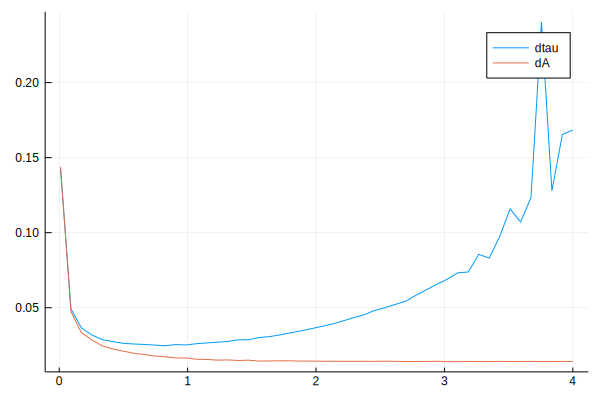

In [53]:
using Plots
plot(df_mean.dt, df_mean.dtau_mean,label="dtau")
plot!(df_mean.dt, df_mean.dA_mean,label="dA")

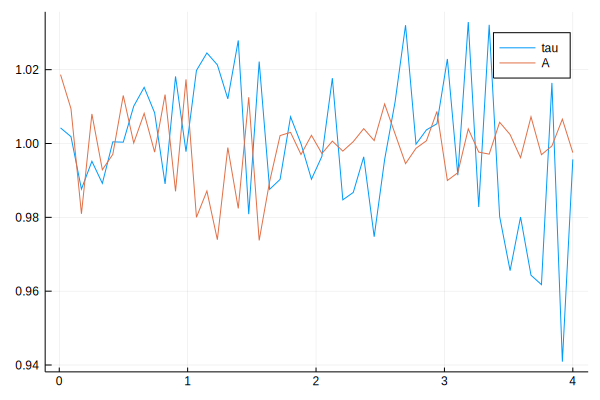

In [58]:
using Plots
plot(df_mean.dt, df_mean.tau_mean,label="tau")
plot!(df_mean.dt, df_mean.A_mean,label="A")

In [61]:
using CSV
CSV.write("OUEM_sN05.csv",df_mean)

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260


"OUEM_sN05.csv"